
### **Insider Threat: Unsupervised EDA**
#### This notebook performs a purely **unsupervised** Exploratory Data Analysis (EDA) on the aggregated feature table.

### **EDA Goals:**
#### 1.  **Connect & Load:** Load data from the DuckDB database.
#### 2.  **Data Quality:** Check for missing values, data types, and duplicates.
#### 3.  **Feature Categorization:** Group the 70+ features into logical types (counts, ratios, categories, etc.).
#### 4.  **Univariate Analysis:** Understand the distribution and skew of key numerical features.
#### 5.  **Multivariate Analysis:** Find redundant features and relationships (Correlation Heatmap).
#### 6.  **Review Categorical Features:** Examine the value counts for text-based features.






#### Setup and Configuration

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb

# --- Configuration ---
DUCKDB_PATH = '../../dataset/unsupervised_dataset.duckdb' 
TABLE_NAME = 'user_features'     

#### Load Data

In [3]:
try:
    con = duckdb.connect(database=DUCKDB_PATH, read_only=True)
    df = con.query(f"SELECT * FROM {TABLE_NAME}").to_df()
    con.close()

    if df.empty:
        print(f"ERROR: No data loaded from table '{TABLE_NAME}'. The DataFrame is empty.")
    else:
        print(f"--- Successfully loaded {len(df)} users from DuckDB table '{TABLE_NAME}' ---")

except Exception as e:
    print(f"--- Could not load data from DuckDB ---")
    print(f"Database Path: {DUCKDB_PATH}")
    print(f"Table Name: {TABLE_NAME}")
    print(f"Error: {e}")

--- Successfully loaded 1000 users from DuckDB table 'user_features' ---


##### Data Overview and Quality

In [4]:
# --- 3.1. DataFrame Info ---
print("--- DataFrame Info (Data Types & Non-Nulls) ---")
df.info()

# --- 3.2. Missing Values ---
print("\n--- Missing Value Counts ---")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])
if missing_counts.sum() == 0:
    print("No missing values found. Excellent.")

# --- 3.3. Duplicate Users ---
print("\n--- Duplicate User Check ---")
if 'user_id' in df.columns:
    duplicate_users = df['user_id'].duplicated().sum()
    if duplicate_users == 0:
        print("No duplicate 'user_id's. Excellent.")
    else:
        print(f"WARNING: Found {duplicate_users} duplicate 'user_id's. These must be resolved.")
else:
    print("WARNING: 'user_id' column not found. Skipping duplicate user check.")

# --- 3.4. Descriptive Statistics ---
print("\n--- Descriptive Statistics (Numerical Features) ---")
print(df.describe().T)

--- DataFrame Info (Data Types & Non-Nulls) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 71 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     1000 non-null   object 
 1   total_logon_events          1000 non-null   int64  
 2   logon_count                 1000 non-null   float64
 3   logoff_count                1000 non-null   float64
 4   logon_unique_pcs            1000 non-null   int64  
 5   after_hours_logons          1000 non-null   float64
 6   weekend_logons              1000 non-null   float64
 7   logon_ratio                 1000 non-null   float32
 8   logon_after_hours_ratio     1000 non-null   float32
 9   logon_weekend_ratio         1000 non-null   float32
 10  total_device_events         265 non-null    Int64  
 11  connect_count               265 non-null    float64
 12  disconnect_count            265 non-null   

#### Feature Categorization

In [5]:
# --- 4.1. Identify Feature Types ---

# These are identifiers and should be dropped before modeling
id_cols = ['user_id', 'psychometric_employee_name', 'ldap_employee_name']

# Filter out ID columns that don't exist in the DataFrame
id_cols = [col for col in id_cols if col in df.columns]

# Find categorical columns (anything that's 'object' or 'category' type)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.drop(id_cols, errors='ignore').tolist()

# Find numerical columns (everything else, excluding IDs and categorical)
numerical_cols = df.columns.drop(id_cols + categorical_cols).tolist()

print(f"--- Feature Categories Identified ---")
print(f"ID Columns ({len(id_cols)}): {id_cols}")
print(f"Categorical Cols ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical Cols ({len(numerical_cols)}): {numerical_cols[:5]}... (first 5)")


# --- 4.2. Review Categorical Value Counts ---
print("\n--- Value Counts for Top Categorical Features ---")

if not categorical_cols:
    print("No categorical features found to review.")
else:
    # Let's look at the LDAP features
    ldap_categorical = ['unique_roles', 'unique_business_units', 'unique_functional_units',
                        'unique_departments', 'unique_teams', 'unique_supervisors']
    
    for col in ldap_categorical:
        if col in df.columns:
            print(f"\nValue counts for '{col}':")
            # Get top 10 most frequent values
            top_10 = df[col].value_counts(normalize=True).head(10)
            print(top_10)
            
            num_unique = df[col].nunique()
            print(f"Total unique values for '{col}': {num_unique}")
            
            if num_unique > 50:
                print(f"WARNING: '{col}' has > 50 unique values. This may create too many features if One-Hot Encoded. Consider binning or feature hashing.")
        else:
            print(f"\nSkipping '{col}' (not in DataFrame).")

--- Feature Categories Identified ---
ID Columns (3): ['user_id', 'psychometric_employee_name', 'ldap_employee_name']
Categorical Cols (0): []
Numerical Cols (68): ['total_logon_events', 'logon_count', 'logoff_count', 'logon_unique_pcs', 'after_hours_logons']... (first 5)

--- Value Counts for Top Categorical Features ---
No categorical features found to review.


#### Univariate Analysis (Feature Distributions)

--- Plotting Numerical Feature Distributions ---


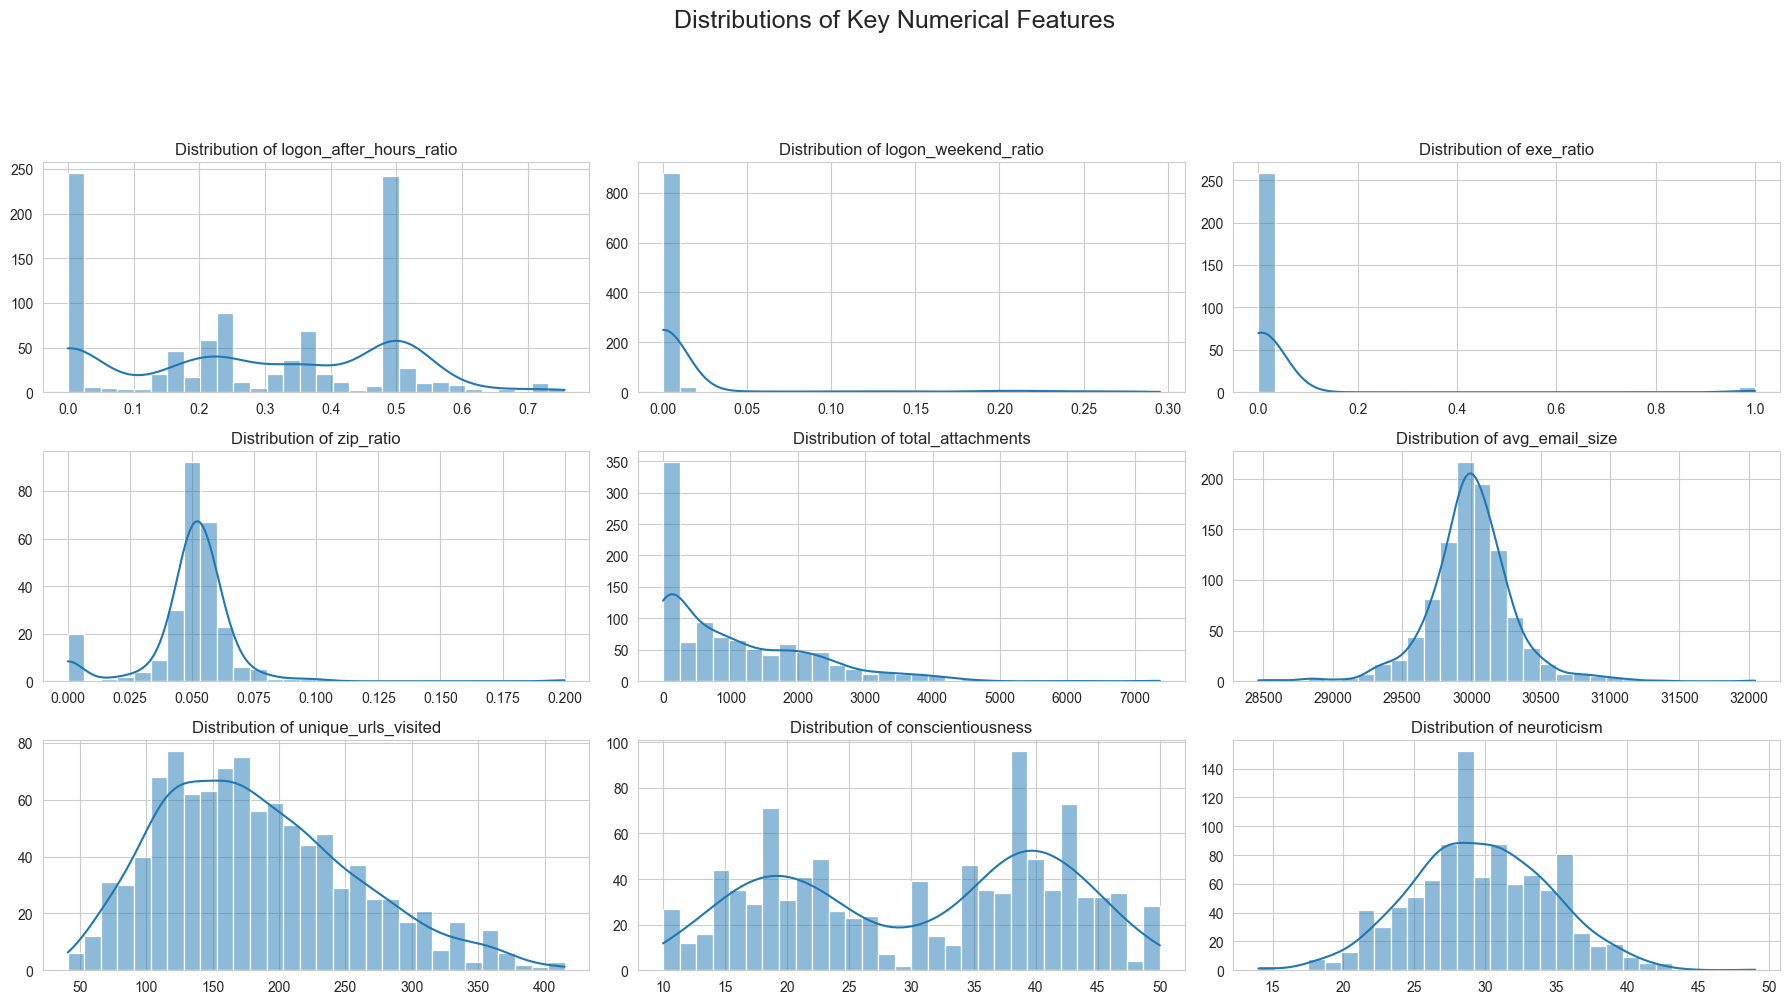

In [6]:
print("--- Plotting Numerical Feature Distributions ---")
sns.set_style('whitegrid')

# Select a few key features from your list
features_to_plot = [
    'logon_after_hours_ratio',
    'logon_weekend_ratio',
    'exe_ratio',
    'zip_ratio',
    'total_attachments',
    'avg_email_size',
    'unique_urls_visited',
    'conscientiousness',
    'neuroticism'
]

# Filter list to only columns that actually exist in the dataframe
features_to_plot = [f for f in features_to_plot if f in df.columns]

if features_to_plot:
    plt.figure(figsize=(18, 10))
    plt.suptitle("Distributions of Key Numerical Features", fontsize=18, y=1.03)
    
    # Calculate grid size
    n_features = len(features_to_plot)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols # Ceiling division
    
    for i, col in enumerate(features_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel('')
        plt.ylabel('')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("None of the selected 'features_to_plot' exist in the DataFrame. Skipping histogram plots.")

# %% [markdown]
# **Univariate Analysis - Key Takeaways:**
#
# * **Right-Skewed Data:** You will likely see that features like `logon_after_hours_ratio`, `exe_ratio`, and `zip_ratio` are **heavily right-skewed**. Most users have a value of 0, with a long tail.
# * **This is GOOD!** This is exactly what we're looking for. Unsupervised anomaly detection models (like Isolation Forest) are *designed* to find these rare, high-value outliers in the tails.
# * **Psychometrics:** The `conscientiousness` and `neuroticism` scores will likely appear more normally (bell-curve) distributed.


#### Multivariate Analysis (Redundant Features)

--- Calculating Correlation Matrix ---


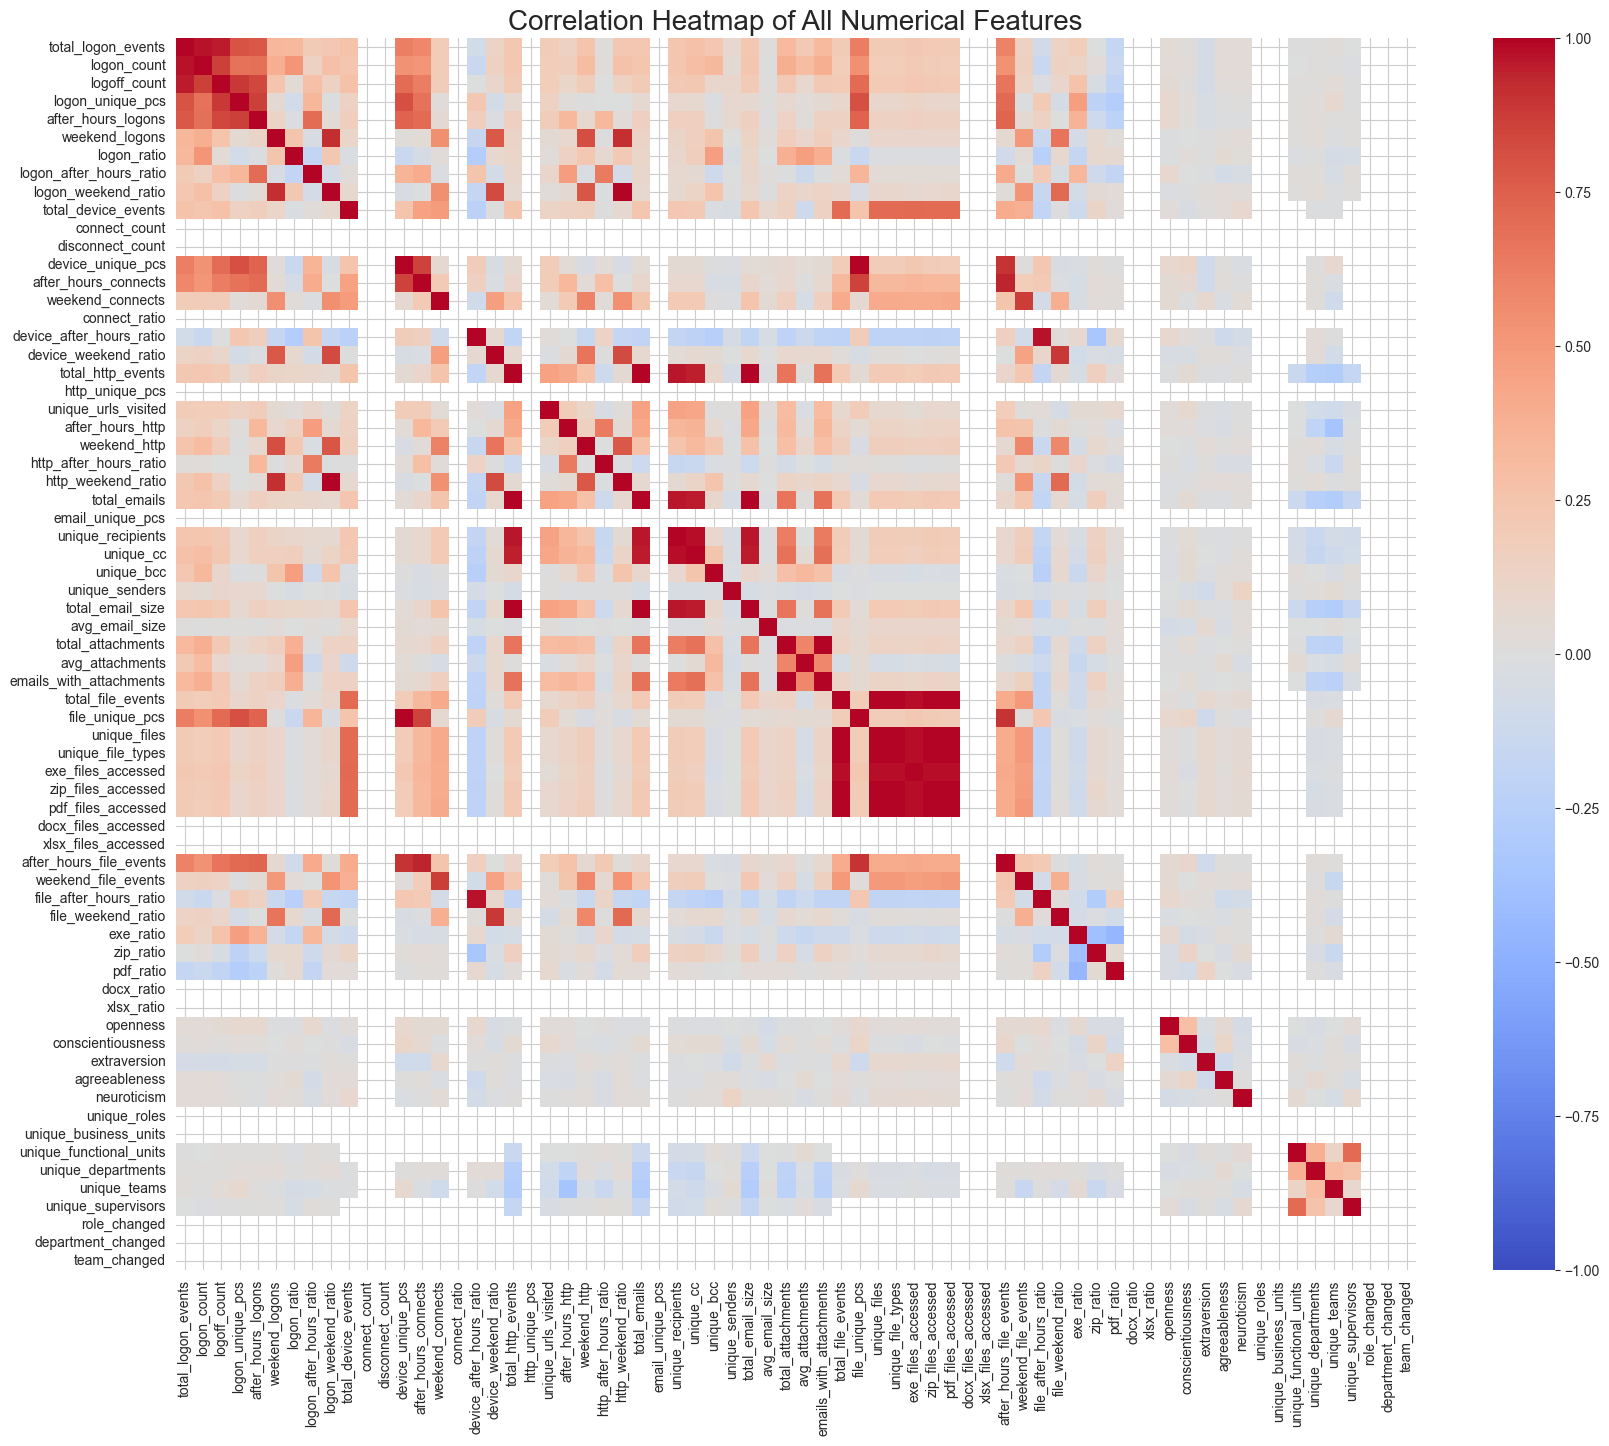


--- Top 20 Most Correlated Feature Pairs (Redundancy Check) ---
total_file_events    unique_file_types      0.999995
unique_files         unique_file_types      0.999995
unique_file_types    total_file_events      0.999995
                     unique_files           0.999995
total_email_size     total_emails           0.999957
total_emails         total_email_size       0.999957
unique_file_types    pdf_files_accessed     0.999647
pdf_files_accessed   unique_file_types      0.999647
                     unique_files           0.999639
                     total_file_events      0.999639
unique_files         pdf_files_accessed     0.999639
total_file_events    pdf_files_accessed     0.999639
device_unique_pcs    file_unique_pcs        0.998518
file_unique_pcs      device_unique_pcs      0.998518
total_emails         total_http_events      0.998117
total_http_events    total_emails           0.998117
total_email_size     total_http_events      0.998093
total_http_events    total_email_s

In [7]:
# With 70+ features, many will be redundant (e.g., `logon_count` and `total_logon_events`). A correlation heatmap is the best way to find them.
print("--- Calculating Correlation Matrix ---")

if numerical_cols:
    # Calculate correlation matrix only on numerical features
    corr_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of All Numerical Features', fontsize=20)
    plt.show()

    # --- 6.2. Find Highly Correlated Pairs ---
    # A heatmap is nice, but this is more actionable.
    print("\n--- Top 20 Most Correlated Feature Pairs (Redundancy Check) ---")
    corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
    corr_pairs = corr_pairs[corr_pairs < 1.0] # Remove self-correlation (1.0)
    print(corr_pairs.head(20))
else:
    print("No numerical columns found to generate a correlation heatmap.")

In [ ]:
# %% [markdown]
# ## 7. EDA Summary & Next Steps
#
# * **EDA Goal:** **COMPLETE.** We have explored the unsupervised characteristics of the data.
#
# * **Key Findings:**
#     1.  **Data Quality:** (Pending output) Assuming the data is clean with no missing values.
#     2.  **Feature Types:** We have a mix of numerical and categorical features. The categorical features (like `unique_departments`) will need to be **One-Hot Encoded** for modeling.
#     3.  **Redundancy:** The dataset is likely highly redundant (e.g., `logon_count` & `total_logon_events`, `total_attachments` & `emails_with_attachments`). We should **drop one** from each highly correlated (e.g., > 0.9) pair.
#     4.  **Feature Skew:** Key behavioral indicators (`exe_ratio`, `after_hours_logons`) are likely heavily right-skewed. This is ideal for anomaly detection.
#
# * **Next Steps:**
#     1.  **Preprocessing:** Create a final modeling dataset by:
#         * Dropping ID columns (`user_id`, etc.).
#         * Dropping one feature from each highly-correlated pair.
#         * One-Hot Encoding all categorical features.
#     2.  **Train Unsupervised Model:** Train an **Isolation Forest** on this preprocessed, purely numerical data to generate anomaly scores.